# Skin Lesion Segmentation and attribute Classification Dataset

First load the dataset from huggingface

In [60]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("jtz18/skin-lesion")
dataset

/Users/jon/code/school/t8/DeepLearning/50.039-DL/venv/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for jtz18/skin-lesion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/jtz18/skin-lesion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label0', 'label1', 'label2', 'label3', 'label4'],
        num_rows: 2594
    })
    validation: Dataset({
        features: ['image', 'label0', 'label1', 'label2', 'label3', 'label4'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label0', 'label1', 'label2', 'label3', 'label4'],
        num_rows: 1000
    })
})

Each image may have multiple labels, so we will a id2label dictionary to map the label id to the label name  
There are a total of 5 class attributes. Each image may have more than 1 class attribute associated with it.


In [61]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jtz18/skin-lesion"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
id2label

{0: 'globules',
 1: 'milia_like_cyst',
 2: 'negative_network',
 3: 'pigment_network',
 4: 'streaks'}

As seen in the training sample below, each image comes with 5 different masks, each corresponding to a different class attribute.

In [62]:
sample = dataset["train"][0]
sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129>,
 'label0': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label1': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label2': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label3': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label4': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>}

Lets view one of the sample images

(1504, 1129)


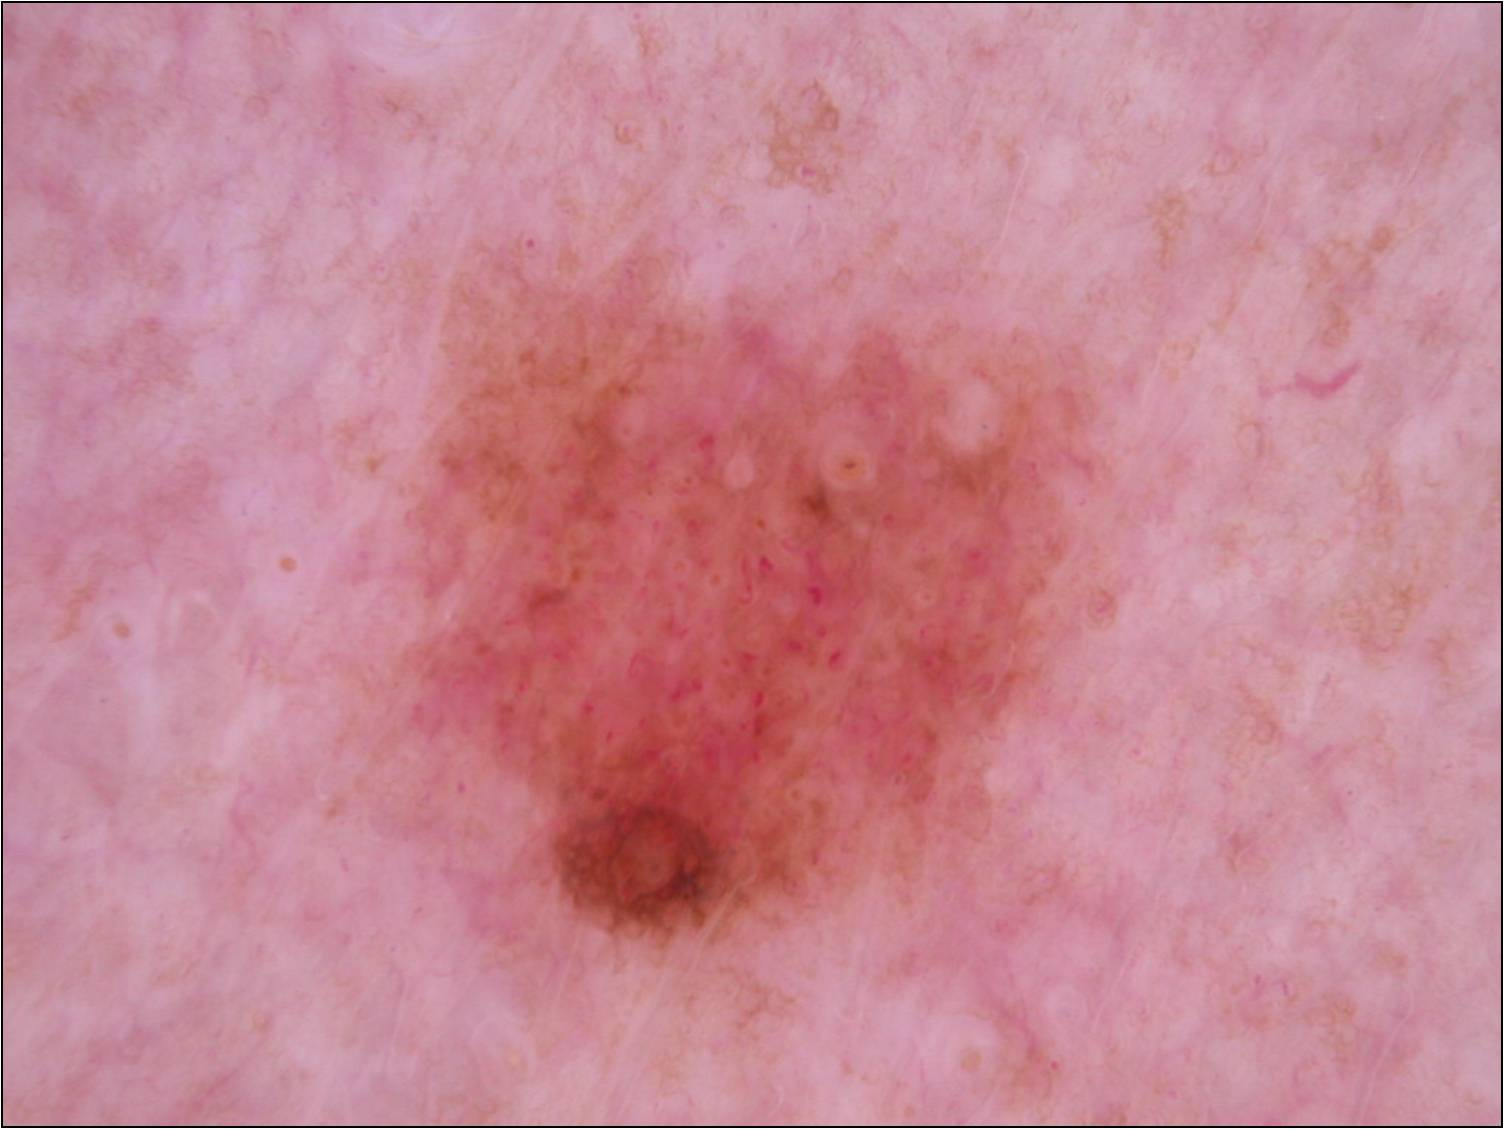

In [63]:
print(sample['image'].size)
sample['image']

Lets view the associated masks for the image. Note that some masks may be completely black, indicating that the class attribute is not present in the image

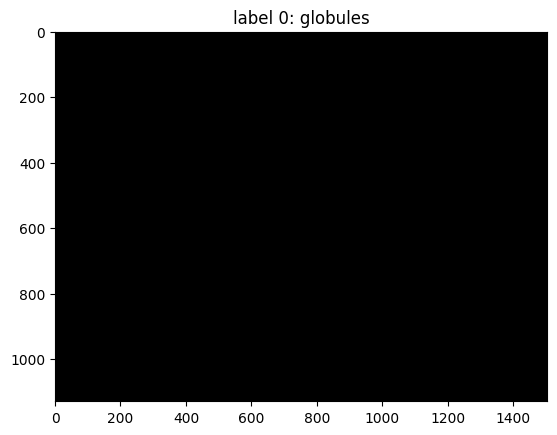

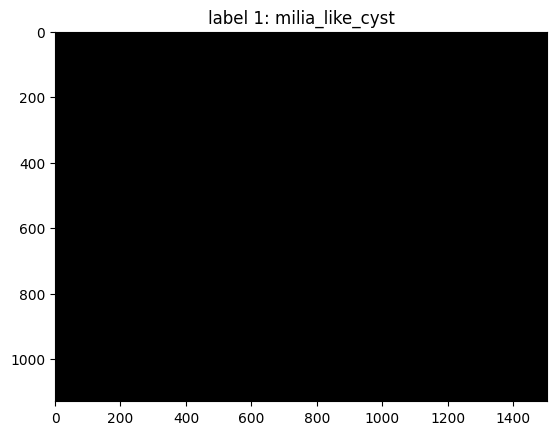

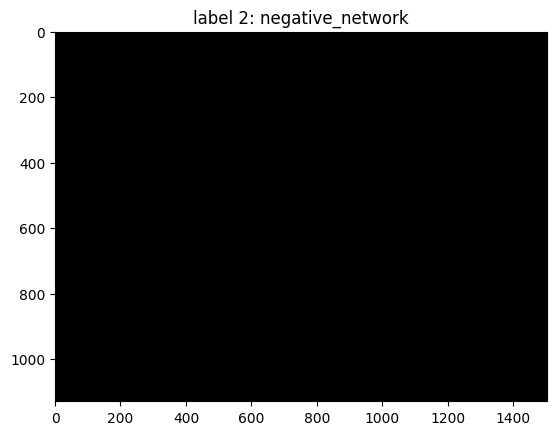

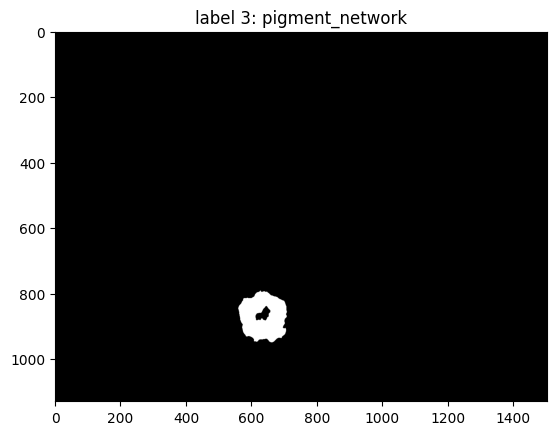

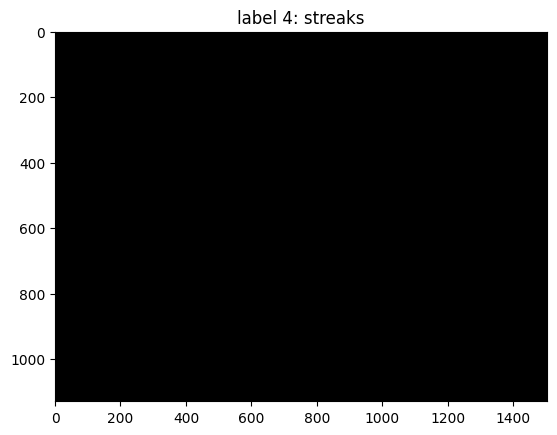

In [64]:
import matplotlib.pyplot as plt

for i in range(5):
    img = sample[f"label{i}"]
    # Display the image
    plt.imshow(img, cmap='gray')

    # Set the title
    plt.title(f'label {i}: {id2label[i]}')

    plt.show()

## Streaming
You could also have the option to stream the dataset if it is too large to fit in memory. This is a simple example of how to do it.  
Although I would not recommend it if we are going to use pytorch dataloaders

In [65]:
# Load the dataset
dataset_stream = load_dataset("jtz18/skin-lesion", streaming=True)
dataset_stream

IterableDatasetDict({
    train: IterableDataset({
        features: ['image', 'label0', 'label1', 'label2', 'label3', 'label4'],
        n_shards: 1
    })
    validation: IterableDataset({
        features: ['image', 'label0', 'label1', 'label2', 'label3', 'label4'],
        n_shards: 1
    })
    test: IterableDataset({
        features: ['image', 'label0', 'label1', 'label2', 'label3', 'label4'],
        n_shards: 1
    })
})

In [66]:
sample = next(iter(dataset['train']))
sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129>,
 'label0': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label1': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label2': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label3': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>,
 'label4': <PIL.PngImagePlugin.PngImageFile image mode=L size=1504x1129>}

(1504, 1129)


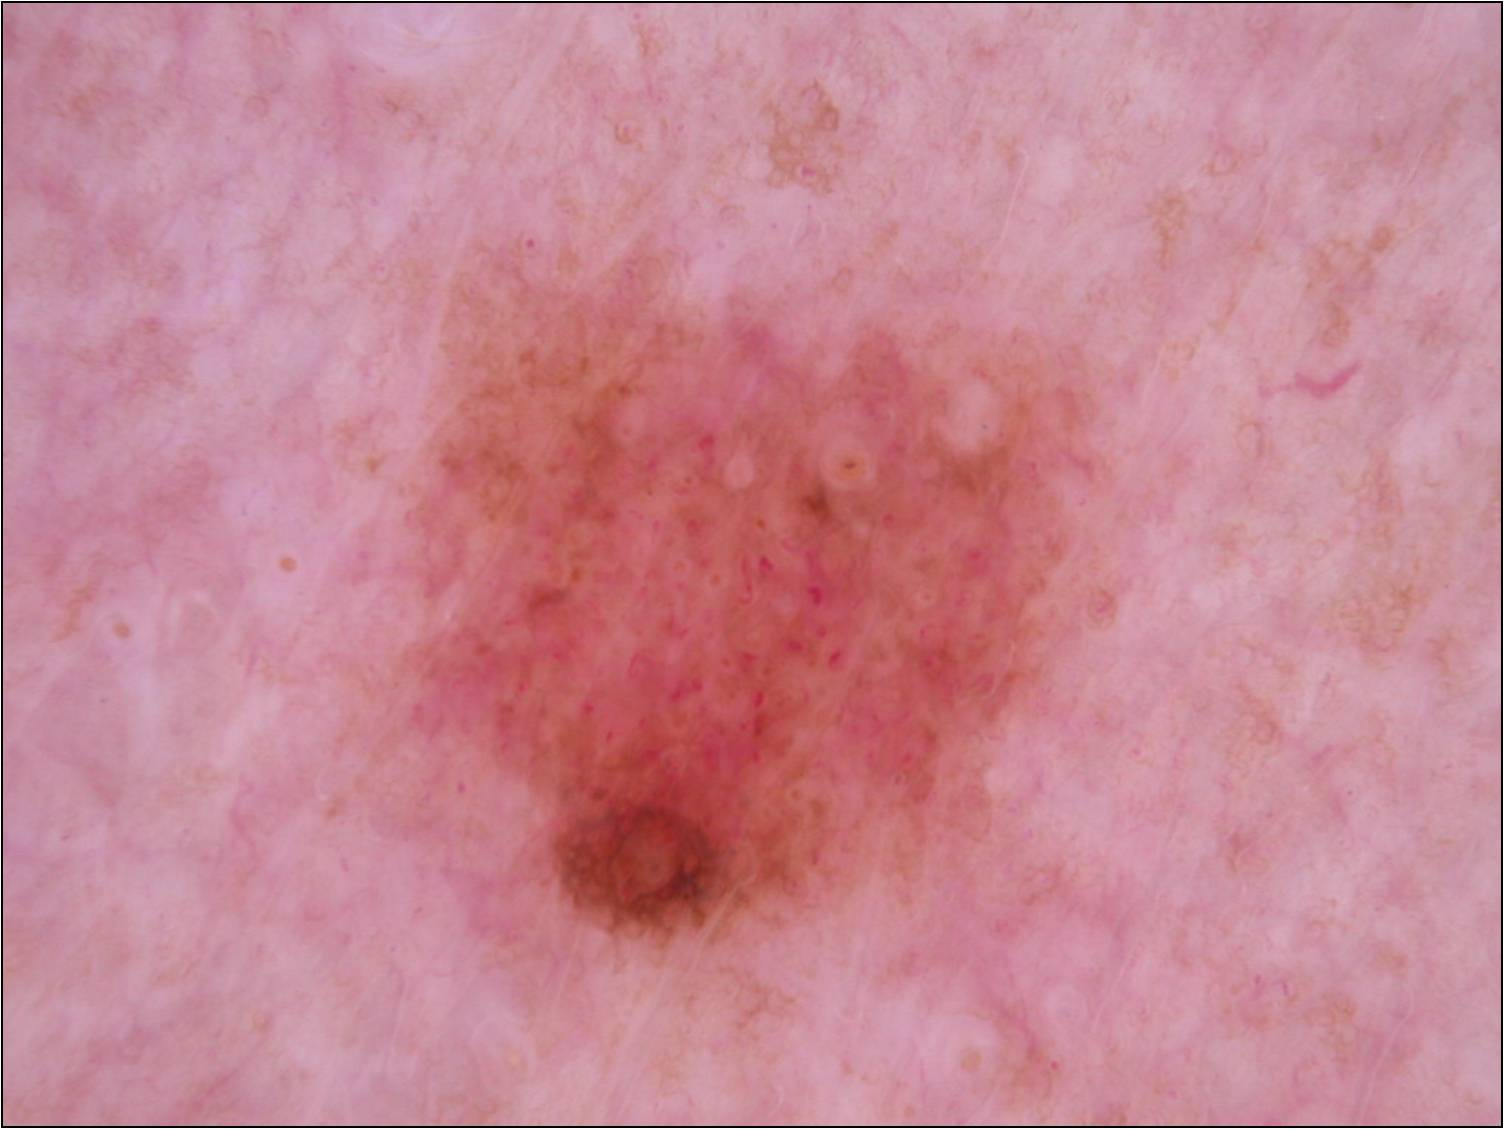

In [67]:
print(sample['image'].size)
sample['image']

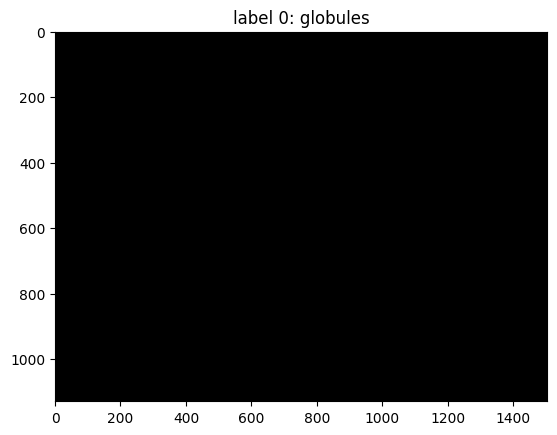

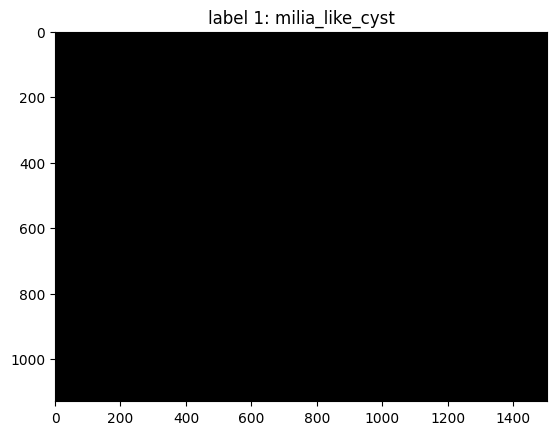

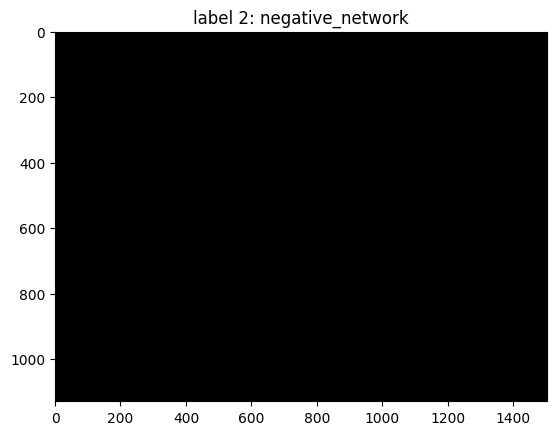

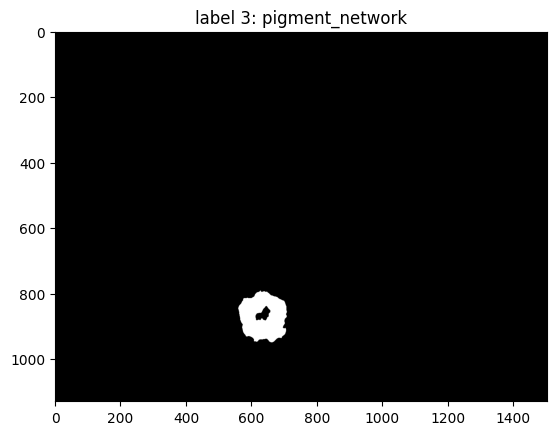

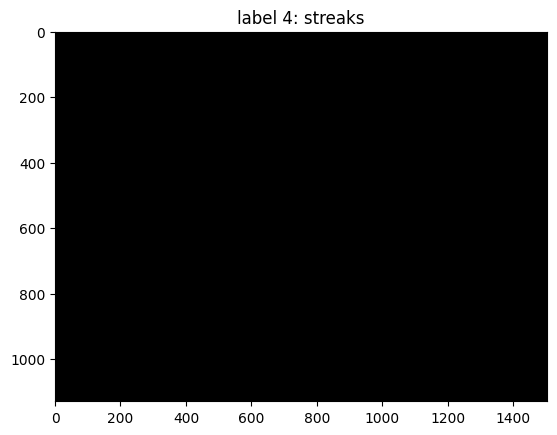

In [68]:
import matplotlib.pyplot as plt

for i in range(5):
    img = sample[f"label{i}"]
    # Display the image
    plt.imshow(img, cmap='gray')

    # Set the title
    plt.title(f'label {i}: {id2label[i]}')

    plt.show()

## Visualise Distributions
Lets visualise the distribution of the class attributes in the dataset to see if we have any class imabalances

In [69]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, split, id2label):
  # Add the number of samples
  num_samples = len(dataset[split])

  # Initialize a Counter object
  class_counter = Counter()

  # Iterate over the dataset
  for _, sample in enumerate(dataset[split]):
      # Iterate over the labels
      for i in range(5):
          # Convert the mask to a numpy array
          mask_array = np.array(sample[f"label{i}"])
          # If there is at least one white pixel, increment the counter for this class
          if np.any(mask_array):
              class_counter[i] += 1

  # Replace the class IDs with class names in the class_counter dictionary
  # Sort the class_counter dictionary by the class IDs
  class_counter_sorted = {id2label[i]: class_counter[i] for i in sorted(class_counter.keys())}


  # Create a bar plot
  labels, values = zip(*class_counter_sorted.items())
  plt.figure(figsize=(10, 6))  # Set the figure size
  plt.bar(labels, values)
  plt.title(f'Class Distribution for {split} set\nNumber of samples: {num_samples}')
  plt.xlabel('Class')
  plt.ylabel('Frequency')

  plt.show()

  return class_counter_sorted, num_samples

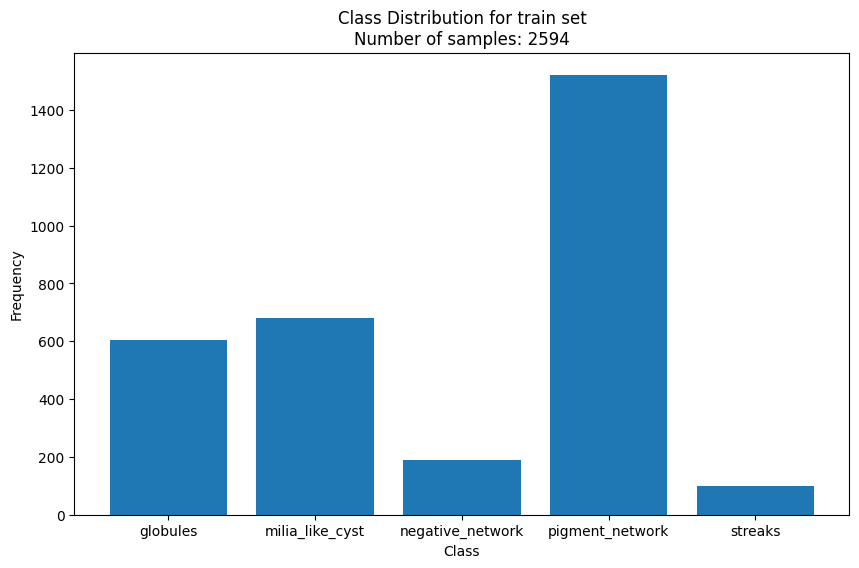

{'globules': 603, 'milia_like_cyst': 682, 'negative_network': 190, 'pigment_network': 1523, 'streaks': 100} 2594


In [70]:
class_counter_train, num_samples = plot_class_distribution(dataset, "train", id2label)
print(class_counter_train, num_samples)

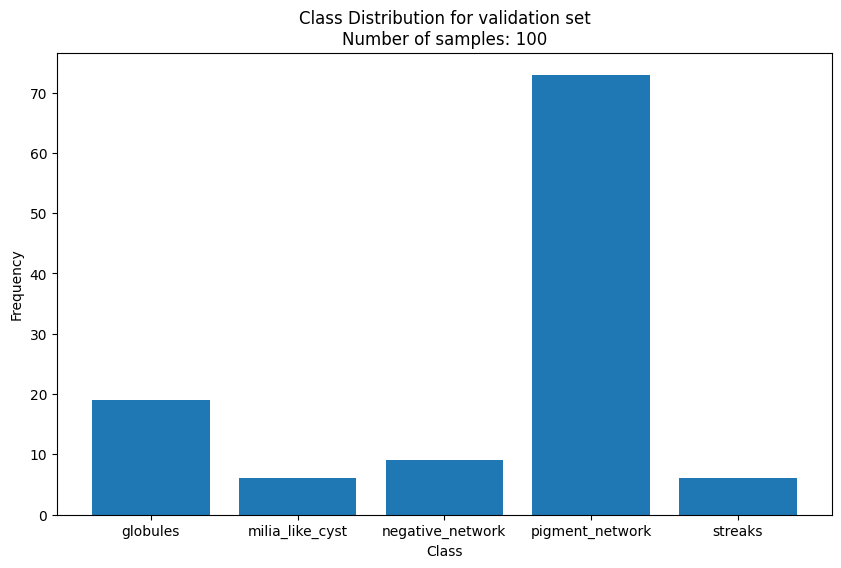

{'globules': 19, 'milia_like_cyst': 6, 'negative_network': 9, 'pigment_network': 73, 'streaks': 6} 100


In [71]:
class_counter_validation, num_samples = plot_class_distribution(dataset, "validation", id2label)
print(class_counter_validation, num_samples)

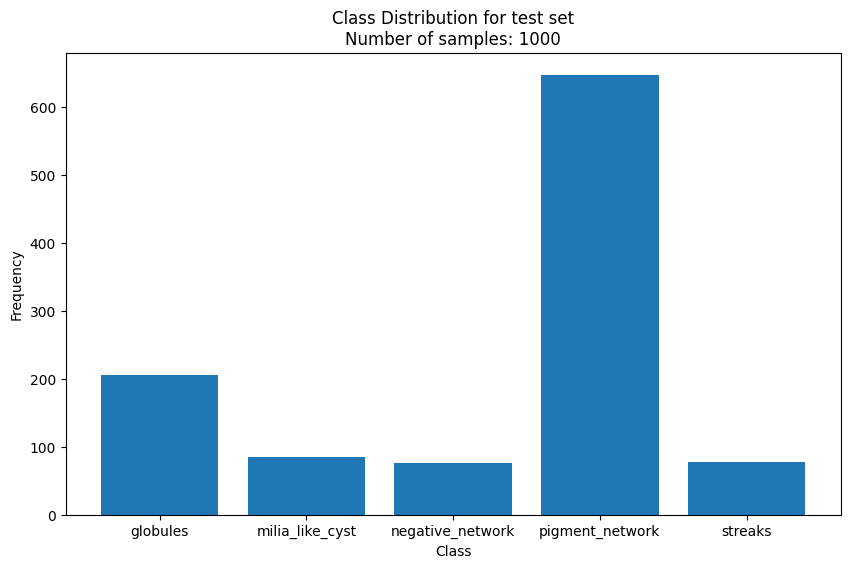

{'globules': 206, 'milia_like_cyst': 85, 'negative_network': 76, 'pigment_network': 648, 'streaks': 77} 1000


In [72]:
class_counter_test, num_samples = plot_class_distribution(dataset, "test", id2label)
print(class_counter_test, num_samples)

Lets Visualise the distribution of the image dimensions in the dataset to get a better understanding

In [73]:
import matplotlib.pyplot as plt

def plot_image_dimensions_distribution(dataset, split):
    dimensions = []

    for sample in dataset[split]:
        width, height = sample['image'].size
        dimensions.append((width, height))


    # Assuming 'dimensions' is a set of tuples containing (width, height) of each image
    widths, heights = zip(*dimensions)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(widths, heights)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(f'Distribution of {split} Image Dimensions\nNo. of Samples: {len(dimensions)}')

    # Get the current axis limits
    xlim = plt.xlim()
    ylim = plt.ylim()

    # Calculate the bin size as the maximum dimension divided by the desired number of bins
    bin_size_width = max(widths) // 100
    bin_size_height = max(heights) // 100

    plt.subplot(1, 2, 2)
    plt.hist2d(widths, heights, bins=[np.arange(0, max(widths)+1, bin_size_width), np.arange(0, max(heights)+1, bin_size_height)], cmap='terrain')
    plt.colorbar(label='Number of Images')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(f'Distribution of {split} Image Dimensions\nNo. of Samples: {len(dimensions)}')

    # Set the axis limits to be the same as the scatter plot
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

    return dimensions

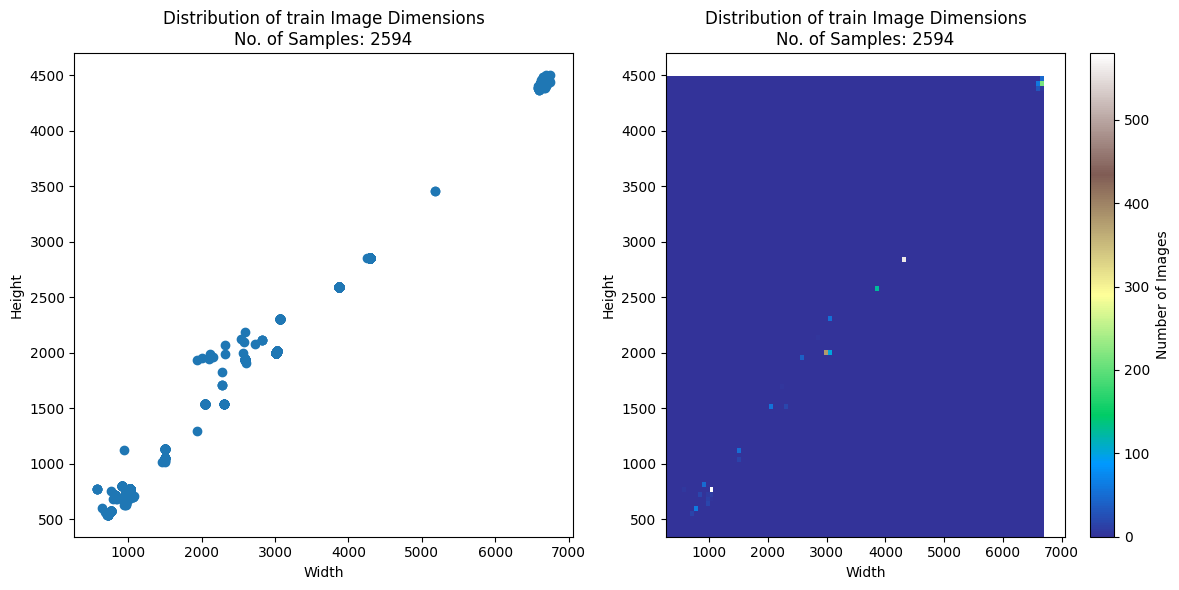

In [74]:
dimension_train = plot_image_dimensions_distribution(dataset, "train")

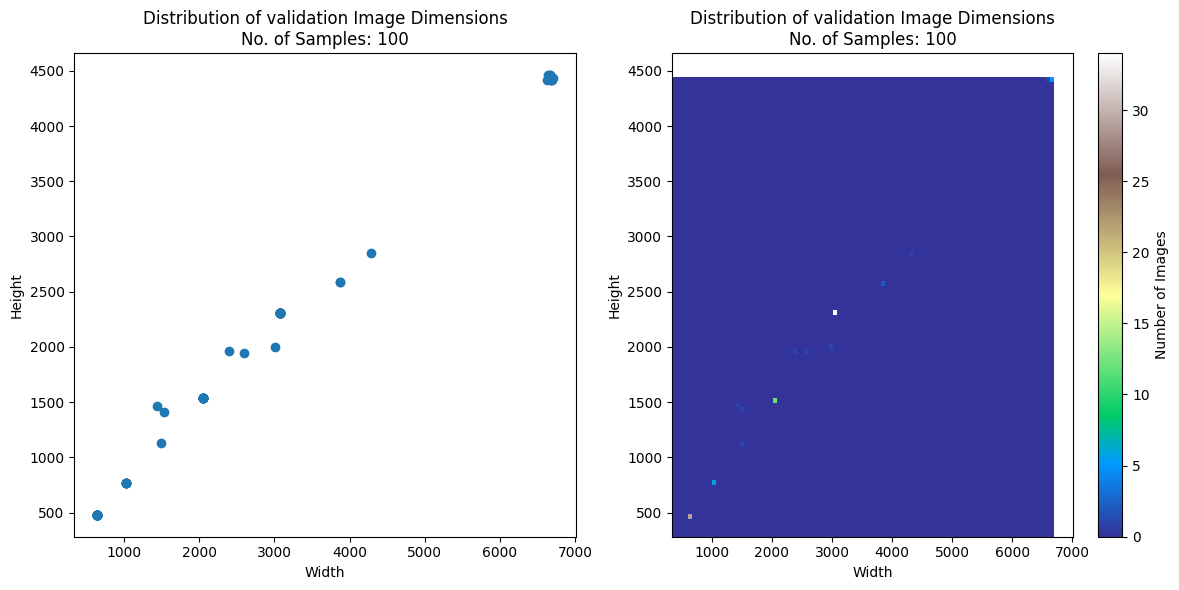

In [75]:
dimension_validation = plot_image_dimensions_distribution(dataset, "validation")

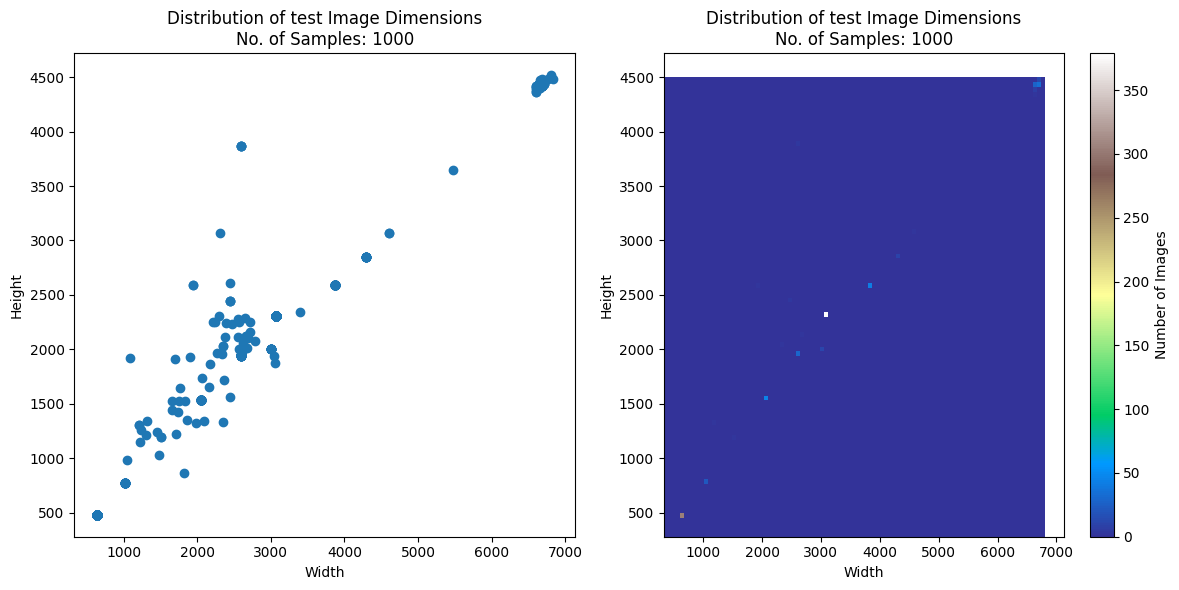

In [76]:
dimension_test = plot_image_dimensions_distribution(dataset, "test")